In [1]:
import numpy as np
import os
import random


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
from read_HiC import name_chromosomes
import seaborn as sns

import sys
path=r'C:\Users\31649\Documents\genome analysis\genome_topology\functions'
sys.path.append(path)

from plotting_tools import set_layout
from genome_topology import normalize_psc
from genome_topology import get_matrix
from genome_topology import fractal_dimension
from genome_topology import make_graph
from plotting_tools import save_figures
from matrix_analysis import PlotMatrix_SelectFraction
from matrix_analysis import Select_entangled_fraction
from statistical_analysis import comparison_distributions

In [3]:
path = 'data/bacteria'

data = pd.read_csv(f'{path}/NT331_LB-e_R1.csv')

In [6]:
threshold = data['Counts'].quantile(0.90)
data_thresh = data[data['Counts'] >= threshold]
data_thresh = data_thresh.sort_values('Index1')

In [7]:
data_thresh


,Unnamed: 0,Index1,Index2,Counts
0,0,0.0,0.0,790.642578
91108,91108,0.0,4580000.0,38.526527
45,45,0.0,90000.0,18.071016
88619,88619,0.0,4520000.0,22.581882
55,55,0.0,100000.0,28.783894
...,...,...,...,...
93143,93143,4620000.0,4620000.0,1023.580261
93853,93853,4620000.0,4640000.0,61.637753
93557,93557,4630000.0,4630000.0,1042.347534
93854,93854,4630000.0,4640000.0,184.678268


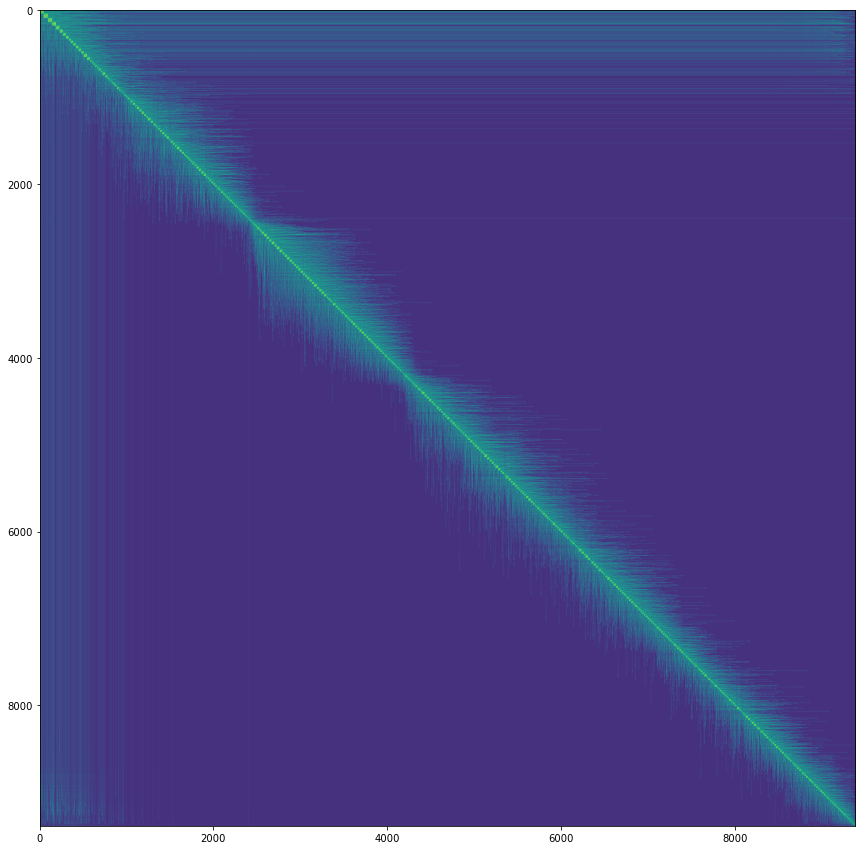

In [8]:



#length1 = (data_thresh['end1'] -  data_thresh['start1'])//2
#data_thresh['position1']=  pd.Series(data_thresh['start1'] + length1)
    
#length2 = (data_thresh['end2'] -  data_thresh['start2'])//2
#data_thresh['position2']=  pd.Series(data_thresh['start2'] + length2)

    
index = [data_thresh['Index1'], data_thresh['Index2']]

index=np.array(index)
index= np.transpose(index)

N_contacts= len(index)
    
mat, psc = get_matrix(index, 'bacteria')

plt.figure(figsize = (15, 15))
plt.imshow(mat)

Split the bacterial matrix in portions, discard all those contacts that are formed between the first and the last portion. The matrix is flipped, check the index


<AxesSubplot:xlabel='Counts', ylabel='Count'>

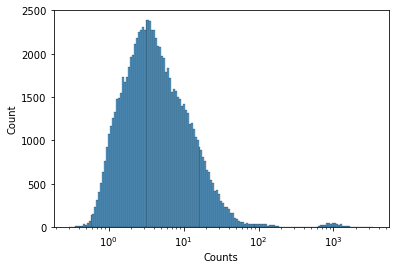

In [22]:
sns.histplot(x = 'Counts', data = data, log_scale = True)

In [2]:
resolution = '80'

path = 'data/zoomify processed'
samples = ['Control1', 'Control2', 'Treated1', 'Treated2']
control1 = pd.DataFrame()
control2 = pd.DataFrame()
treated1 = pd.DataFrame()
treated2 = pd.DataFrame()

frames = [None]*4

for ind, sample in enumerate(samples):
    df =  pd.read_csv(f'{path}/{sample}{resolution}', sep = '\t', header = None, 
                      names = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'count', 'balanced'],
                     dtype={'chrom1': 'str'})
    
    
    frames[ind] = df.dropna().reset_index(drop=True)
    sample_col = [sample] * len(frames[ind])
    frames[ind]['Sample'] = sample_col

In [3]:
control1 = frames[0]
control2 = frames[1]
treated1 = frames[2]
treated2 = frames[3]

In [4]:

dfs = [control1, control2, treated1, treated2]
df = pd.concat(dfs)


In [5]:
type_counts = 'count'
contacts = pd.DataFrame()
total_data = list(control1[type_counts]) + list(control2[type_counts]) + list(treated1[type_counts]) + list(treated2[type_counts])
data = {'counts': total_data}
data = pd.DataFrame(data)
quantile_thresh = 0.992
threshold = data['counts'].quantile(quantile_thresh)

for frame in frames:
    frame = frame[frame[type_counts]>= threshold]
    frame = pd.DataFrame(frame)
    frames = [contacts, frame]
    contacts = pd.concat(frames)

    
new_index = np.linspace(1, len(contacts), len(contacts), dtype = int)
contacts['Index'] = new_index
contacts = contacts.set_index('Index')

In [12]:
res = float(resolution)

n_start_bins = 150
start = n_start_bins* res * 1000
increment = 50* res * 1000
max_bin = np.max(control1['end1'])
cutoffs = np.arange(start, max_bin , increment, dtype = int)

In [13]:
len(cutoffs)

60

In [30]:
chromosomes = control1['chrom1'].unique()
path_df = 'results counts/cumulative'
samples = ['Control1', 'Control2', 'Treated1', 'Treated2']
samples = ['Control1']
chromosomes = ['3', '4']

N_contacts=np.zeros(len(chromosomes))
P=np.zeros((len(cutoffs), len(chromosomes)))
S=np.zeros((len(cutoffs), len(chromosomes)))
X=np.zeros((len(cutoffs), len(chromosomes)))
Dim_fractal = np.zeros(len(chromosomes))
r2_fractalfit = np.zeros(len(chromosomes))
clustering = np.zeros(len(chromosomes))


for sample in samples:
    contacts_sample = contacts[contacts['Sample'] == sample]
    
    for t, chrom in enumerate(chromosomes):
        print(chrom)
        contacts_chr= contacts_sample[(contacts_sample['chrom1']== chrom) & (contacts_sample['chrom2']==chrom)]
        
        for j, cutoff in enumerate(cutoffs):
            print(cutoff)
            data_sel = contacts_chr[(contacts_chr['end1']<= cutoff)&(contacts_chr['end2']<= cutoff)]
        
            length1 = (data_sel['end1'] -  data_sel['start1'])//2
            data_sel['position1']=  pd.Series(data_sel['start1'] + length1)
    
            length2 = (data_sel['end2'] -  data_sel['start2'])//2
            data_sel['position2']=  pd.Series(data_sel['start2'] + length2)
    
            index = [data_sel['position1'], data_sel['position2']]
            counts = np.array(data_sel['count'])
            index=np.array(index)
            index= np.transpose(index)

            N_contacts[t]= len(index)
    
            mat, psc = get_matrix(index, chrom)
            #write_topology_matrix(mat, pathfile, namefile = f'{chrom}_{selection_sample}_{resolution}')
            P[j, t], S[j, t], X[j, t]=normalize_psc(psc, N_contacts[t])
    
            #Dim_fractal[t], r2_fractalfit[t] = fractal_dimension(mat, plot_fig=0)
    
            #G=make_graph(index)
            #clustering[t] = nx.average_clustering(G)
            
        df = {'Cut-off': cutoffs, 'Parallel (%)': P[:,t], 'Series (%)': S[:,t], 
              'Cross (%)': X[:,t]}
          #, 'Clustering coeff': clustering,
          #    'Fractal dimension': Dim_fractal, 'R2': r2_fractalfit,
          #    'N contacts': N_contacts}
        df = pd.DataFrame(df)

        df.to_feather(f'{path_df}/cumulative_{sample}_{chrom}_{resolution}_{quantile_thresh}.feather ')
        
            
            
    
    

3
48000000
52800000
57600000
62400000
67200000
72000000
76800000
81600000
86400000
91200000
96000000
100800000
105600000
110400000
115200000
120000000
124800000
129600000
134400000
139200000
144000000
148800000
153600000
158400000
163200000
168000000
172800000
177600000
182400000
187200000
192000000
196800000
201600000
206400000
211200000
216000000
220800000
225600000
230400000
235200000
240000000
244800000
4
48000000
52800000
57600000
62400000
67200000
72000000
76800000
81600000
86400000
91200000
96000000
100800000
105600000
110400000
115200000
120000000
124800000
129600000
134400000
139200000
144000000
148800000
153600000
158400000
163200000
168000000
172800000
177600000
182400000
187200000
192000000
196800000
201600000
206400000
211200000
216000000
220800000
225600000
230400000
235200000
240000000
244800000


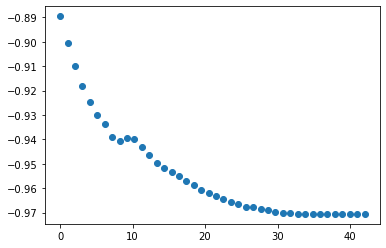

In [32]:
arr = -S[:,0]
x = np.linspace(0, len(arr), len(arr))
plt.scatter(x, arr)

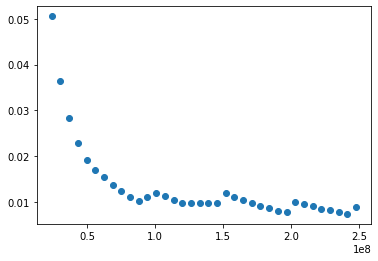

In [3]:
data = pd.read_feather('results counts/cumulative/cumulative_Control2_1_160_0.99.feather')
par = data['Parallel (%)']
cut = data['Cut-off']

plt.scatter(cut, par)

In [97]:
len(cutoffs)

63